In [1]:
#%matplotlib notebook
#from matplotlib import style
#style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
today_str = session.query(func.max(Measurement.date)).first()[0]
today = dt.datetime.strptime(today_str, '%Y-%m-%d').date()
today_1y = today - dt.timedelta(days=365.25)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement).filter(Measurement.date > today_1y).filter(Measurement.date <= today)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(precipitation.statement, session.bind)
df_prec = df.set_index('date')

# Sort the dataframe by date
df_prec = df_prec.sort_index()
df_prec

,id,station,prcp,tobs
date,,,,
2016-08-24,2365,USC00519397,0.08,79.0
2016-08-24,8826,USC00517948,NaN,78.0
2016-08-24,14609,USC00519281,2.15,77.0
2016-08-24,7332,USC00514830,2.28,80.0
2016-08-24,5092,USC00513117,2.15,76.0
2016-08-24,19203,USC00516128,1.45,74.0
2016-08-24,11852,USC00519523,1.22,79.0
2016-08-25,2366,USC00519397,0.08,80.0
2016-08-25,8827,USC00517948,0.00,81.0


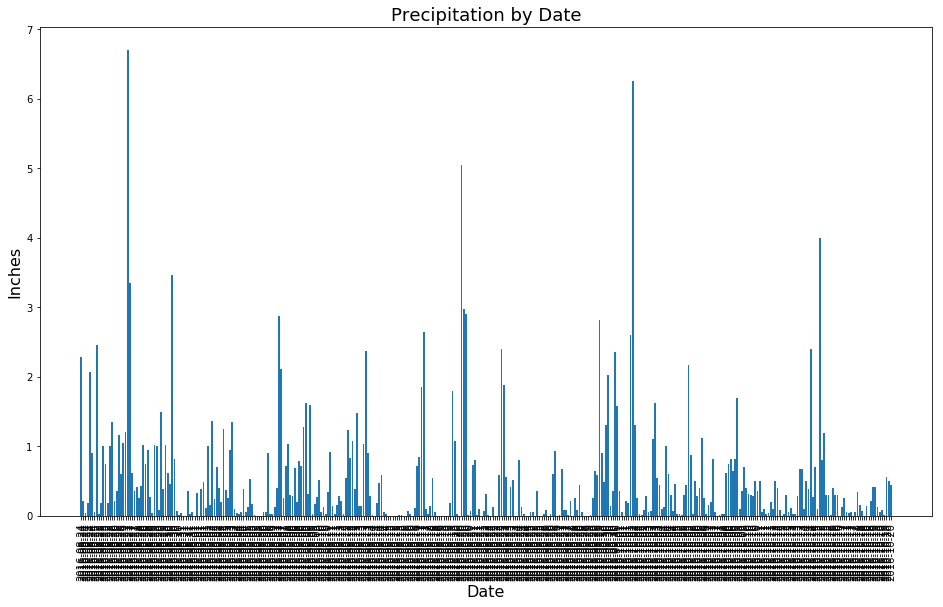

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure(figsize = (16,9))
ax = plt.axes()

b1 = np.array(df_prec['prcp'])
ax.bar(df_prec.index, b1)

# Set plot features and font size
ax.set_title('Precipitation by Date', fontsize = 18)
ax.set_ylabel('Inches', fontsize = 16)
ax.set_xlabel('Date', fontsize = 16)

# Space ticks and labels to be every 3rd, label text rotated 90 degrees
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels = df_prec.index.values, rotation = 90)

plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prec.describe()

,id,prcp,tobs
count,2223.000000,2015.000000,2223.000000
mean,10159.397211,0.176462,74.578947
std,5604.268703,0.460288,4.612232
min,2365.000000,0.000000,58.000000
25%,5287.500000,0.000000,71.000000
50%,8931.000000,0.020000,75.000000
75%,14751.500000,0.130000,78.000000
max,19550.000000,6.700000,87.000000


In [13]:
# How many stations are available in this dataset?
stations = session.query(func.count(Station.station)).all()[0][0]
stations

9

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
act_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()

for state in act_station:
    print(state)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_ma_id = session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.prcp))).\
    first()

sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
ma_station = session.query(*sel).filter(Measurement.station == station_ma_id[0]).all()

ma_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

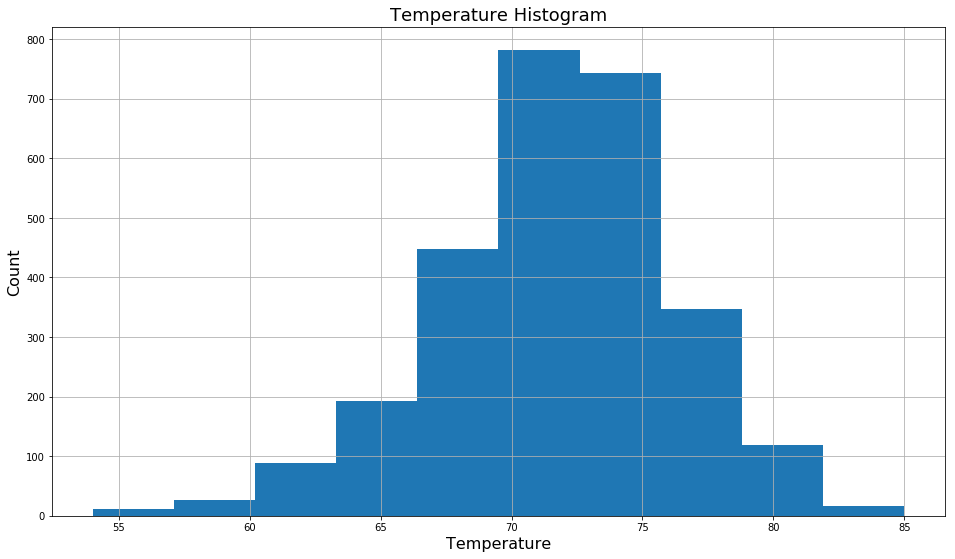

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_to_id = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.tobs))).\
    first()

sel = [Measurement.station, Measurement.tobs]
temperature = session.query(*sel).filter(Measurement.station == station_to_id[0])

df2 = pd.read_sql(temperature.statement, session.bind)

# Sort the dataframe by date
df_temp = df2.sort_index()

# # Use Pandas Plotting with Matplotlib to plot the data
fig2 = plt.figure(figsize = (16,9))
ax2 = plt.axes()

ax2.hist(df_temp['tobs'])

# Set plot features and font size
ax2.set_title('Temperature Histogram', fontsize = 18)
ax2.set_ylabel('Count', fontsize = 16)
ax2.set_xlabel('Temperature', fontsize = 16)
ax2.grid(True)

In [17]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
   
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = dt.datetime.strptime(end_date, '%Y-%m-%d').date()
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-06-01'
trip_end = '2017-06-15'

ts_1 = dt.datetime.strptime(trip_start, '%Y-%m-%d').date() - dt.timedelta(days=365.25)
te_1 = dt.datetime.strptime(trip_end, '%Y-%m-%d').date() - dt.timedelta(days=365.25)

ts_1 = ts_1.strftime('%Y-%m-%d')
te_1 = te_1.strftime('%Y-%m-%d')

vacay = calc_temps(ts_1, te_1)
print(vacay)

[(64.0, 74.15625, 81.0)]


(0.5, 1.5)

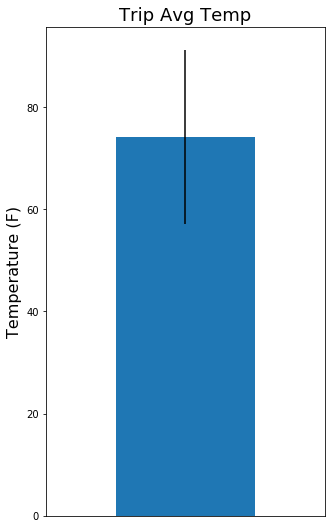

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Use Pandas Plotting with Matplotlib to plot the data
fig3 = plt.figure(figsize = (5,9))
ax3 = plt.axes()

ax3.bar(x = [1], height = vacay[0][1], width = 0.5, yerr = [vacay[0][2]-vacay[0][0]])

# Set plot features and font size
ax3.set_title('Trip Avg Temp', fontsize = 18)
ax3.set_ylabel('Temperature (F)', fontsize = 16)
ax3.set_xticks([])
ax3.set_xlim(0.5, 1.5)

In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_precip = session.query(Measurement).filter(Measurement.date > dt.datetime.strptime('2016-06-01', '%Y-%m-%d').\
    date()).filter(Measurement.date <= dt.datetime.strptime('2016-06-15', '%Y-%m-%d').date())

stat_meta = session.query(Station)

sel = [Measurement.station, Station.name, func.sum(Measurement.prcp).label('prec_tot'), Station.latitude, Station.longitude, Station.elevation]
comb = session.query(*sel).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(desc('prec_tot'))

trip_df = pd.read_sql(comb.statement, session.bind)
trip_df

,station,name,prec_tot,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1068.09,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",588.64,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",382.62,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",295.68,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",234.49,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",131.62,21.27160,-157.81680,3.0
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",92.68,21.31520,-157.99920,0.9
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",70.87,21.49920,-158.01110,306.6
8,USC00517948,"PEARL CITY, HI US",43.44,21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    
    sel = [func.min(Measurement.tobs).label('min'), func.avg(Measurement.tobs).label('avg'), func.max(Measurement.tobs).label('max')]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings

ts = dt.datetime.strptime(trip_start, '%Y-%m-%d').date()
te = dt.datetime.strptime(trip_end, '%Y-%m-%d').date()
td = te - ts

count = 0
date_list = []
md_list = []
for i in range(td.days+1):
    days = ts + dt.timedelta(days=count)
    date_list.append(dt.date.strftime(ts + dt.timedelta(days=count),'%Y-%m-%d'))
    md_list.append(dt.date.strftime(days, '%m-%d'))
    count += 1

# Loop through the list of %m-%d strings and calculate the normals for each date
min_list = []
avg_list = []
max_list = []
for day in md_list:
    min_list.append(daily_normals(day)[0].min)
    avg_list.append(daily_normals(day)[0].avg)
    max_list.append(daily_normals(day)[0].max)


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norm_df = pd.DataFrame({'Date': date_list,
                        'Min': min_list,
                        'Avg': avg_list,
                        'Max': max_list})
norm_df = norm_df.set_index('Date')
norm_df

,Min,Avg,Max
Date,,,
2017-06-01,64.0,74.614035,81.0
2017-06-02,65.0,74.400000,81.0
2017-06-03,65.0,74.034483,80.0
2017-06-04,65.0,73.818182,81.0
2017-06-05,68.0,74.854545,81.0
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0
2017-06-08,70.0,75.586207,81.0
2017-06-09,69.0,75.152542,81.0


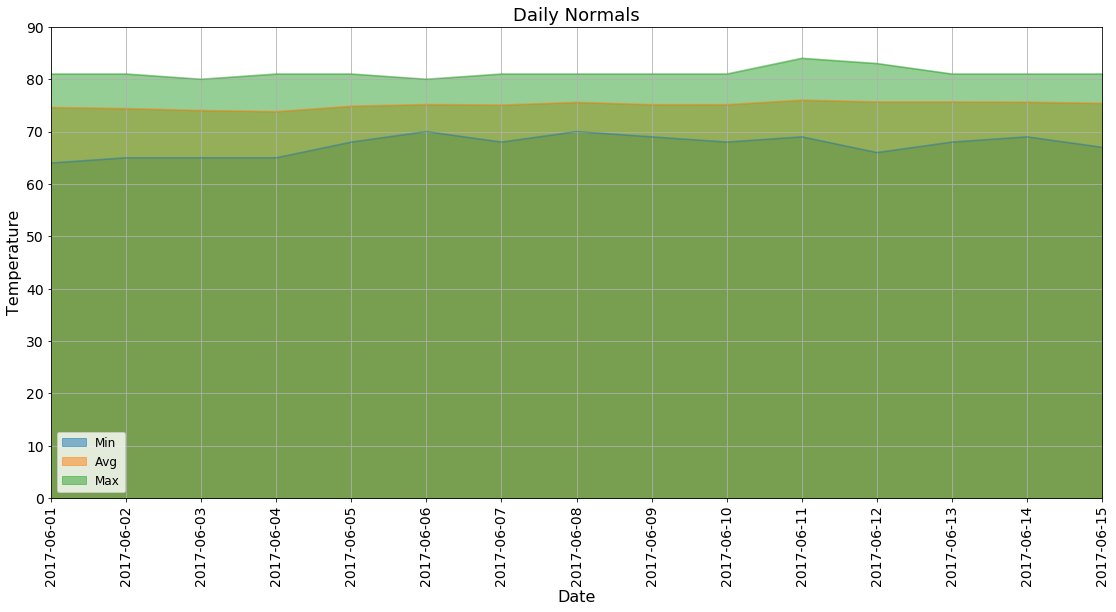

In [66]:
# Plot the daily normals as an area plot with `stacked=False`

ax = norm_df.plot.area(figsize = (16,9), stacked=False)

# Assign labels for stackplot

# Set plot features and fontsize
ax.set_title('Daily Normals', fontsize = 18)
ax.set_ylabel('Temperature', fontsize = 16)
ax.set_xlabel('Date', fontsize = 16)
ax.set_xticks(ticks = np.arange(0,15,1))
ax.set_xticklabels(labels = norm_df.index, rotation = 90)
ax.set(ylim = (0, 90), xlim = (0, 14))

# Assign legend location and label size
ax.legend(loc = 'lower left', fontsize = 12)
ax.grid(True)
ax.tick_params(labelsize = 14)
plt.tight_layout(pad = 2.5)

plt.show()